# Project 3 - Recommender Systems

## Association Rule mining, Collaborative Filtering and Content Based Filtering


### Brett Hallum, Mridul Jain, and Solomon Ndungu


# Introduction

The goal of this project is to analyze the Movilens Dataset. We will use this data to generate the movie recommendations for specific users. This can be done by looking at the movies they watched and rated and comparing it to users that have watched similar movies and rated movies in a similar manner. By using the concepts of collaborative filtering, we can find " Movie X LIKED BY SIMILAR USERS as User-A " and can recommended this movie to User-A as well.

# Understanding the Data
GroupLens Research has collected and made available rating data sets from the MovieLens web site (http://movielens.org). The data sets were collected over various periods of time, depending on the size of the set.
There are multiple files in this dataset. There are 2 files that we are interested in u.data - this has the userId, the movieId, the rating and the date that rating was given. 

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 1997 through April 22nd, 1998. This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set.

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   


u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.


# Data Exploration and Visualization


In [1]:
import os
os.chdir('C:\Users\Halltrino\Desktop\MDS Downloads\Data Mining\Project 3\ml-100k')
os.getcwd()

'C:\\Users\\Halltrino\\Desktop\\MDS Downloads\\Data Mining\\Project 3\\ml-100k'

In [2]:
import numpy as np 
import pandas as pd

In [3]:
#Files to be used for analysis

dataFile='u.data'
movieInfoFile='u.item'

In [4]:
#We are passing the header explicitly as there is no header info in the files
#We are not interested in all the columns of 'u.item'. We are going to use only 0,1 columns from this file.

data=pd.read_csv(dataFile,sep="\t",header=None,names=['userId','itemId','rating','timestamp'])
movieInfo=pd.read_csv(movieInfoFile,sep="|", header=None, index_col=False,
                     names=['itemId','title'], usecols=[0,1])

In [5]:
print data.head()
print '\n'
print movieInfo.head()

   userId  itemId  rating  timestamp
0     196     242       3  881250949
1     186     302       3  891717742
2      22     377       1  878887116
3     244      51       2  880606923
4     166     346       1  886397596


   itemId              title
0       1   Toy Story (1995)
1       2   GoldenEye (1995)
2       3  Four Rooms (1995)
3       4  Get Shorty (1995)
4       5     Copycat (1995)


In [6]:
# Merging the two files together into one single dataFrame. We will use this dataFrame in the further analysis.

data=pd.merge(data,movieInfo,left_on='itemId',right_on="itemId")

# Create a combined csv file that we will use to load in pyspark for Latent Factor Collaborative filtering \
# using ALTERNATING LEAST SQUARES method
data.to_csv('combined_user_movie_file.csv')
print (data.head())

   userId  itemId  rating  timestamp         title
0     196     242       3  881250949  Kolya (1996)
1      63     242       3  875747190  Kolya (1996)
2     226     242       5  883888671  Kolya (1996)
3     154     242       3  879138235  Kolya (1996)
4     306     242       5  876503793  Kolya (1996)


In [7]:
print data.shape
print data.head()

(100000, 5)
   userId  itemId  rating  timestamp         title
0     196     242       3  881250949  Kolya (1996)
1      63     242       3  875747190  Kolya (1996)
2     226     242       5  883888671  Kolya (1996)
3     154     242       3  879138235  Kolya (1996)
4     306     242       5  876503793  Kolya (1996)


In [8]:
data=pd.DataFrame.sort_values(data,['userId','itemId'],ascending=[0,1])

# Let's see how many users and how  many movies there are 
numUsers=max(data.userId)
numMovies=max(data.itemId)

moviesPerUser=data.userId.value_counts()
usersPerMovie=data.title.value_counts()

print 'Number of Users: ', numUsers
print 'Number of Movies: ', numMovies
print '\n'
print 'Number of users that rate a particular Movie: \n\n', usersPerMovie.head()
print '\n'
print 'Number of movies rated by particular User: \n\n', moviesPerUser.head()

Number of Users:  943
Number of Movies:  1682


Number of users that rate a particular Movie: 

Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: title, dtype: int64


Number of movies rated by particular User: 

405    737
655    685
13     636
450    540
276    518
Name: userId, dtype: int64


The above shows Star Wars had the highest number of rating and user # 405 rated the highest number of movies.

### Next we examine ratings by single user.

In [9]:
data.head()

,userId,itemId,rating,timestamp,title
23781,943,2,5,888639953,GoldenEye (1995)
65410,943,9,3,875501960,Dead Man Walking (1995)
35098,943,11,4,888639000,Seven (Se7en) (1995)
43773,943,12,5,888639093,"Usual Suspects, The (1995)"
57040,943,22,4,888639042,Braveheart (1995)


In [10]:
# Since userID 405 is the most active user and seems like a movie buff. Its a good idea to check which movies he liked
# Lets see user ID 405's highest and lowest rated movies.

user_405 = data.loc[data.userId == 405]
user_405_HighestRatings = user_405.loc[user_405.rating > 4]
user_405_LowestRatings = user_405.loc[user_405.rating < 2]

### Specific User Ratings

Below we show the top ratings and bottom ratings for a given user. In this case we use user 405, who rated the most movies, to show the movies he rated at the top and the movies he rated at the bottom.

In [11]:
print '5 Highest Rated Movies by UserID 405', user_405_HighestRatings.head(5)
print '\n5 Lowest Rated Movies by UserID 405', user_405_LowestRatings.head(5)

5 Highest Rated Movies by UserID 405        userId  itemId  rating  timestamp                       title
43709     405      12       5  885545306  Usual Suspects, The (1995)
56861     405      22       5  885545167           Braveheart (1995)
14992     405      23       5  885545372          Taxi Driver (1976)
68788     405      38       5  885548093             Net, The (1995)
48303     405      47       5  885545429              Ed Wood (1994)

5 Lowest Rated Movies by UserID 405        userId  itemId  rating  timestamp                 title
23701     405       2       1  885547953      GoldenEye (1995)
72281     405      27       1  885546487       Bad Boys (1995)
89654     405      30       1  885549544  Belle de jour (1967)
87587     405      31       1  885548579   Crimson Tide (1995)
6166      405      32       1  885546025          Crumb (1994)


We start by creating a fuction that can be used to return the top number (N) of Movies for a specified user

In [12]:
#Function to return the topN Movies for a specific user. N is an arbitrary number, and can be changed as needed.

def topN(activeUser,N):
    user_topN = data.loc[data.userId == activeUser]
    return user_topN.loc[user_topN.rating > 4].head(N)

Example below shows, in desceding order, the top ten movie raters

In [13]:
moviesPerUser.index[:10]

Int64Index([405, 655, 13, 450, 276, 416, 537, 303, 234, 393], dtype='int64')

In [14]:
TopMoviesList = pd.DataFrame()

Num_Active_Critics_to_Check = 20
Num_Movies_by_Each_Critic = 500

for i in moviesPerUser.index[:Num_Active_Critics_to_Check]:
    TopMoviesList = TopMoviesList.append(topN(i,Num_Movies_by_Each_Critic))

del TopMoviesList['userId']
del TopMoviesList['timestamp']

#Atleast 20% of the critics are agreein to the top rating for the movies

TopMoviesList = TopMoviesList.title.value_counts()
TopMoviesList = TopMoviesList[TopMoviesList>Num_Active_Critics_to_Check/5]

print '\nMovies that are rated highly by most active movie raters in the dataset\n\n', TopMoviesList.head(10)


Movies that are rated highly by most active movie raters in the dataset

Star Wars (1977)                                                               15
Godfather, The (1972)                                                          13
Usual Suspects, The (1995)                                                     11
Monty Python and the Holy Grail (1974)                                         10
Pulp Fiction (1994)                                                            10
Apocalypse Now (1979)                                                           9
Jaws (1975)                                                                     9
Schindler's List (1993)                                                         9
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)     9
Empire Strikes Back, The (1980)                                                 9
Name: title, dtype: int64


The above analysis is insightful and shows at least 20% of the critics agree to the top rating for the movies

As in the personalized recommendation scenario, the introduction of new users or new items can 
cause the cold start problem, as there will be insufficient data on these new entries for the 
collaborative filtering to work accurately. Next we can quickly find the active raters, we call them Movie Critics, and see which movies they rate highest and which movies they rate lowest. These movies in general can be recommended to the people who have not rated or seen any movies yet, and are new to the system.

In [15]:
#Function to return the bottom N Movies for a specific user. N is an arbitrary number, and can be changed as needed.

def bottomN(activeUser,N):
    user_bottomN = data.loc[data.userId == activeUser]
    return user_bottomN.loc[user_bottomN.rating < 3].head(N)

In [16]:
bottomMoviesList = pd.DataFrame()

Num_Active_Critics_to_Check = 20
Num_Movies_by_Each_Critic = 500

for i in moviesPerUser.index[:Num_Active_Critics_to_Check]:
    bottomMoviesList = bottomMoviesList.append(bottomN(i,Num_Movies_by_Each_Critic))

del bottomMoviesList['userId']
del bottomMoviesList['timestamp']

#Atleast 20% of the critics are agreein to the bottom rating for the movies

bottomMoviesList = bottomMoviesList.title.value_counts()
bottomMoviesList = bottomMoviesList[bottomMoviesList>Num_Active_Critics_to_Check/5]

print '\nMovies that are rated low by most active movie raters in the dataset\n\n', bottomMoviesList.head(10)


Movies that are rated low by most active movie raters in the dataset

Batman Forever (1995)                8
Very Brady Sequel, A (1996)          7
Volcano (1997)                       7
Waterworld (1995)                    7
Die Hard: With a Vengeance (1995)    7
Natural Born Killers (1994)          7
Pretty Woman (1990)                  7
Lord of Illusions (1995)             6
Free Willy (1993)                    6
Long Kiss Goodnight, The (1996)      6
Name: title, dtype: int64


### Analyzing similarities in rating between users

In [17]:
from scipy.spatial.distance import correlation 
def similarity(user1,user2):
    user1=np.array(user1)-np.nanmean(user1) # we are first normalizing user1 by 
    # the mean rating of user 1 for any movie. Note the use of np.nanmean() - this 
    # returns the mean of an array after ignoring and NaN values 
    user2=np.array(user2)-np.nanmean(user2)
    # Now to find the similarity between 2 users
    # We'll first subset each user to be represented only by the ratings for the 
    # movies the 2 users have in common 
    commonItemIds=[i for i in range(len(user1)) if user1[i]>0 and user2[i]>0]
    # Gives us movies for which both users have non NaN ratings 
    if len(commonItemIds)==0:
        # If there are no movies in common 
        return 0
    else:
        user1=np.array([user1[i] for i in commonItemIds])
        user2=np.array([user2[i] for i in commonItemIds])
        return correlation(user1,user2)

In [18]:
# Let's write a function to find the top N favorite movies of a user 
def favoriteMovies(activeUser,N):
    #1. subset the dataframe to have the rows corresponding to the active user
    # 2. sort by the rating in descending order
    # 3. pick the top N rows
    topMovies=pd.DataFrame.sort_values(
        data[data.userId==activeUser],['rating'],ascending=[0])[:N]
    # return the title corresponding to the movies in topMovies 
    return list(topMovies.title)

print favoriteMovies(5,3) # Print the top 3 favorite movies of user 5

['Men in Black (1997)', 'Blade Runner (1982)', 'Empire Strikes Back, The (1980)']


In [19]:
#Creating a very sparse Matrix "user_to_Movie_Rating_Matrix" of UserID and MovieRatig which we will use later 
# on to find the user-user correlation and hence will be able to find which users are similar to each other.

userItemRatingMatrix=pd.pivot_table(data, values='rating',
                                    index=['userId'], columns=['itemId'])

In [20]:
userItemRatingMatrix.head()

itemId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Below we can see some of the most popular algorithms/techniquesavailable to build recommender systems

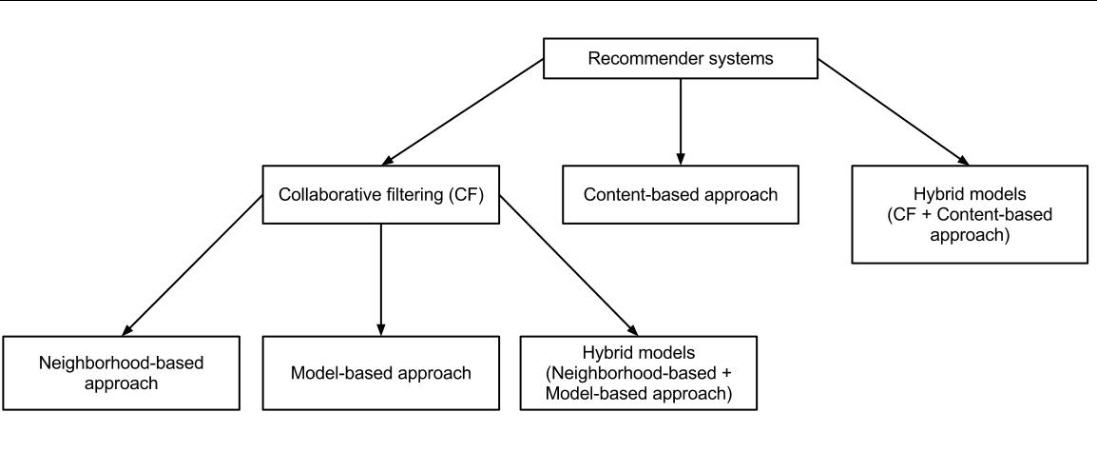

In [21]:
from IPython.display import Image
import pandas as pd
Image(filename='C:\Users\Halltrino\Desktop\MDS Downloads\Data Mining\Project 3\Recommender_Systems_General.jpg')

## GraphLab Recommender System

In [22]:
import graphlab as gl

gl_data = gl.SFrame(data)
print (gl_data.head())

model = gl.recommender.create(gl_data, user_id="userId", item_id="title", target="rating")
results = model.recommend(users=None, k=5)
model.save("my_model")

results.head() # the recommendation output

This non-commercial license of GraphLab Create for academic use is assigned to bhallum@smu.edu and will expire on August 11, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\HALLTR~1\AppData\Local\Temp\graphlab_server_1471580410.log.0


+--------+--------+--------+-----------+----------------------------+
| userId | itemId | rating | timestamp |           title            |
+--------+--------+--------+-----------+----------------------------+
|  943   |   2    |   5    | 888639953 |      GoldenEye (1995)      |
|  943   |   9    |   3    | 875501960 |  Dead Man Walking (1995)   |
|  943   |   11   |   4    | 888639000 |    Seven (Se7en) (1995)    |
|  943   |   12   |   5    | 888639093 | Usual Suspects, The (1995) |
|  943   |   22   |   4    | 888639042 |     Braveheart (1995)      |
|  943   |   23   |   4    | 888638897 |     Taxi Driver (1976)     |
|  943   |   24   |   4    | 875502074 | Rumble in the Bronx (1995) |
|  943   |   27   |   4    | 888639954 |      Bad Boys (1995)       |
|  943   |   28   |   4    | 875409978 |      Apollo 13 (1995)      |
|  943   |   31   |   4    | 888639066 |    Crimson Tide (1995)     |
+--------+--------+--------+-----------+----------------------------+
[10 rows x 5 columns

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 100000 observations with 943 users and 1664 items.

Data prepared in: 0.090586s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12500 / 100000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 12.5              | Not Viable                               |

| 1       | 3.125             | Not Viable                               |

| 2       | 0.78125           | Not Viable                               |

| 3       | 0.195312          | Not Viable                               |

| 4       | 0.0488281         | No Decrease (2.56064 >= 2.47047)         |

| 5       | 0.012207          | 2.05609                                  |

| 6       | 0.00610352        | 2.16991                                  |

| 7       | 0.00305176        | 2.29752                                  |

| 8       | 0.00152588        | 2.36998                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.012207          | 2.05609                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 2.48442           | 1.12567               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 141.637ms    | 2.15402           | 1.04733               | 0.012207    |

| 2       | 281.271ms    | 2.1165            | 1.06604               | 0.012207    |

| 3       | 402.387ms    | 1.97              | 1.036                 | 0.012207    |

| 4       | 516.997ms    | 2.29735           | 1.15946               | 0.012207    |

| 5       | 626.603ms    | 2.90413           | 1.38081               | 0.012207    |

| 6       | 729.201ms    | 2.62694           | 1.32107               | 0.012207    |

| 10      | 1.18s        | 4.16959           | 1.74423               | 0.012207    |

| 11      | 1.35s        | DIVERGED          | DIVERGED              | 0.012207    |

| RESET   | 1.40s        | 2.48424           | 1.12559               |             |

| 1       | 1.54s        | 2.30573           | 1.08466               | 0.00610352  |

| 9       | 2.44s        | 2.48526           | 1.25249               | 0.00610352  |

| 19      | 3.55s        | 2.51392           | 1.31444               | 0.00610352  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 2.45906

Final training RMSE: 1.29079

userId,title,score,rank
943,One Flew Over theCuckoo's Nest (1975) ...,3.78483343391,1
943,Casablanca (1942),3.77590702741,2
943,Amadeus (1984),3.71813389367,3
943,L.A. Confidential (1997),3.70297178613,4
943,Alien (1979),3.68045113689,5
942,"Silence of the Lambs, The(1991) ...",4.2538090971,1
942,"Godfather, The (1972)",4.22904996841,2
942,"Shawshank Redemption, The(1994) ...",4.17975309758,3
942,"Princess Bride, The(1987) ...",4.1675136116,4
942,Fargo (1996),4.16501057415,5


 The system recomends Casablanca(1942) as the current top recommendation for user 943 and user 942

### Movie Simillarity ratings

In [23]:
item_item = gl.recommender.item_similarity_recommender.create(gl_data, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

results = item_item.get_similar_items(k=5)
results.head()

Recsys training: model = item_similarity

Warning: Ignoring columns itemId, timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 100000 observations with 943 users and 1664 items.

Data prepared in: 0.066564s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.001ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.504ms                             | 0                | 0               |

| 49.547ms                            | 100              | 1664            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.055553s

title,similar,score,rank
GoldenEye (1995),Under Siege (1992),0.659618616104,1
GoldenEye (1995),Top Gun (1986),0.623543560505,2
GoldenEye (1995),True Lies (1994),0.617273688316,3
GoldenEye (1995),Batman (1989),0.616143107414,4
GoldenEye (1995),Stargate (1994),0.604969024658,5
Dead Man Walking (1995),Fargo (1996),0.618000686169,1
Dead Man Walking (1995),Leaving Las Vegas (1995),0.590753376484,2
Dead Man Walking (1995),"Godfather, The (1972)",0.529238581657,3
Dead Man Walking (1995),Twelve Monkeys (1995),0.527462303638,4
Dead Man Walking (1995),Jerry Maguire (1996),0.527136862278,5


Per the above analysis GoldenEye(1995) is most similar to Under Siege(1992) so if a user likes any one of the movie, there is a high chance they will like the other one. This item-item matrix will be a big help in determining the relationships between movies one person likes already by ratings and movies they may be interested in that we can recommend.

### Split the test and train data sets

In [24]:
train, test = gl.recommender.util.random_split_by_user(gl_data,
                                                    user_id="userId", item_id="title",
                                                    max_num_users=100, item_test_proportion=0.2)

In [25]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test)

Recsys training: model = item_similarity

Warning: Ignoring columns itemId, timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 97760 observations with 943 users and 1662 items.

Data prepared in: 0.066074s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.006ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.494ms                             | 0                | 2               |

| 50.036ms                            | 100              | 1662            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.081567s


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.61      | 0.0429091904431 |
|   2    |      0.53      | 0.0744869886285 |
|   3    | 0.493333333333 |  0.103385197641 |
|   4    |     0.4575     |  0.124967035172 |
|   5    |     0.454      |  0.148819005988 |
|   6    |      0.44      |  0.174346845901 |
|   7    |      0.42      |   0.1881805572  |
|   8    |    0.39375     |  0.196795131483 |
|   9    | 0.385555555556 |  0.214840970972 |
|   10   |     0.366      |  0.221476117992 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.676870392635004)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
|  925   |   1   | 1.96951662533 |
+--------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (worst)


Above is the evaluation of the test data against the item-item recommender system. This evaluation has a high precision with all cutoffs less than 10 having greater than 35% precision.

Below we show the Root Mean Square Error (RMSE) both by Item and by User. The RMSE is defined as the average difference of the evaluated score and the actual score given to the movie by various users.

In [26]:
print rmse_results.viewkeys()
print rmse_results['rmse_by_item']

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])
+-------------------------------+-------+---------------+
|             title             | count |      rmse     |
+-------------------------------+-------+---------------+
|        Sneakers (1992)        |   3   | 2.70334387852 |
|     Drop Dead Fred (1991)     |   1   |      2.0      |
| Terminator 2: Judgment Day... |   8   | 4.11037103677 |
|    Ruby in Paradise (1993)    |   1   |      4.0      |
|      Jurassic Park (1993)     |   9   | 3.47782205326 |
|  Fried Green Tomatoes (1991)  |   5   | 3.68182413987 |
|       Cliffhanger (1993)      |   4   | 2.89740010347 |
|      Reality Bites (1994)     |   2   | 3.53051894272 |
|      Mary Poppins (1964)      |   3   | 3.32622394357 |
|         Casper (1995)         |   1   | 4.95907067259 |
+-------------------------------+-------+---------------+
[802 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You

### RMSE per user and per item basis

In [27]:
rmse_results['rmse_by_user']

userId,count,rmse
71,5,3.75280877258
112,8,3.12627604164
750,5,2.11865602824
134,5,3.93618426405
285,7,4.34232539231
653,56,2.90251231346
364,6,3.37381441511
932,50,4.14149309464
80,3,4.35889894354
66,7,3.35283520357


### Per User recall and precision

In [28]:
rmse_results['precision_recall_by_user']

userId,cutoff,precision,recall,count
12,1,1.0,0.0769230769231,13
12,2,0.5,0.0769230769231,13
12,3,0.333333333333,0.0769230769231,13
12,4,0.25,0.0769230769231,13
12,5,0.4,0.153846153846,13
12,6,0.5,0.230769230769,13
12,7,0.428571428571,0.230769230769,13
12,8,0.375,0.230769230769,13
12,9,0.333333333333,0.230769230769,13
12,10,0.3,0.230769230769,13


The above results show the precision and recall for a specific user at different cutoffs. A cutoff is how many movies the recommender system tries to predict for the user. At a cutoff of 5, the recommender system correctly predicts the rating given by the user 40% of the time. The recall value of 15.3% at the 5 cutoff says that given 5 movies to rate, the recommender system rates movies high that the user has already rated highly for the user 15% of the time.

In [29]:
import graphlab.aggregate as agg

# we will be using these aggregations
agg_list = [agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')]

# apply these functions to each group (we will group the results by 'k' which is the cutoff)
# the cutoff is the number of top items to look for see the following URL for the actual equation
# https://dato.com/products/create/docs/generated/graphlab.recommender.util.precision_recall_by_user.html#graphlab.recommender.util.precision_recall_by_user
rmse_results['precision_recall_by_user'].groupby('cutoff',agg_list)

# the groups are not sorted

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.30375,0.215424725832,0.283499339266,0.195561492665
10,0.366,0.251880924248,0.221476117992,0.164293030295
36,0.215833333333,0.161773303891,0.413341070071,0.208263445098
26,0.245384615385,0.183391778384,0.348780420411,0.200581796466
41,0.201707317073,0.15417470409,0.433117197319,0.199466519567
3,0.493333333333,0.328227563336,0.103385197641,0.107841686417
1,0.61,0.48774993593,0.0429091904431,0.0616446080683
6,0.44,0.267207784318,0.174346845901,0.143861402391
11,0.355454545455,0.250320455773,0.23287003819,0.167082625866
2,0.53,0.352278299076,0.0744869886285,0.0785919826771


The precision and recall prediction results for different cutoffs are shown above. The precision values over these different cutoffs are above 20% in each case. This means that more than 20% of the time, we are predicting movies for users that they have rated highly already. This is a great result. More specifically, at a cutoff of 16, where 16 movies are chosen for the user, 30.3% of the movies rated highly were found by the recommender system.

## Cross Validated Collaborative Filtering

In the collaborative filtering, instead of comparing each item to one another, the system performs a ranking factorization of the items to calculate their ratings.

In [30]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating")

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 97760 observations with 943 users and 1662 items.

Data prepared in: 0.076573s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12220 / 97760 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 12.5              | Not Viable                               |

| 1       | 3.125             | Not Viable                               |

| 2       | 0.78125           | Not Viable                               |

| 3       | 0.195312          | No Decrease (4.01548 >= 2.48504)         |

| 4       | 0.0488281         | 2.14524                                  |

| 5       | 0.0244141         | 2.11357                                  |

| 6       | 0.012207          | 2.06429                                  |

| 7       | 0.00610352        | 2.21552                                  |

| 8       | 0.00305176        | 2.32438                                  |

| 9       | 0.00152588        | 2.38247                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.012207          | 2.06429                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 2.48184           | 1.12505               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 122.118ms    | 2.18258           | 1.05718               | 0.012207    |

| 2       | 226.218ms    | 2.02736           | 1.03277               | 0.012207    |

| 3       | 337.324ms    | 1.97059           | 1.02056               | 0.012207    |

| 4       | 433.917ms    | 2.0663            | 1.09671               | 0.012207    |

| 5       | 540.019ms    | 2.50611           | 1.27025               | 0.012207    |

| 6       | 655.63ms     | 2.3036            | 1.21581               | 0.012207    |

| 10      | 1.08s        | 2.12408           | 1.13498               | 0.012207    |

| 11      | 1.18s        | 2.20978           | 1.14388               | 0.012207    |

| 20      | 2.06s        | 1.88356           | 1.0487                | 0.012207    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.09491

Final training RMSE: 1.08844


Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.16      | 0.00506161811793 |
|   2    |      0.19      | 0.0188140391179  |
|   3    | 0.183333333333 | 0.0285838563376  |
|   4    |     0.1775     | 0.0330050291128  |
|   5    |     0.166      | 0.0376348271244  |
|   6    | 0.163333333333 | 0.0458083083595  |
|   7    | 0.161428571429 | 0.0547553762853  |
|   8    |     0.1575     | 0.0603133121437  |
|   9    | 0.154444444444 | 0.0644074969904  |
|   10   |     0.152      | 0.0685873691557  |
+--------+----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.1184637921284153)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
|  860   |   13  | 0.479773908151 |
+--------+-------+----------------+
[1 rows x 3 columns]


Pe

In [31]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.140625,0.156718048976,0.103366216944,0.0952850800548
10,0.152,0.18192306066,0.0685873691557,0.0787451109413
36,0.109722222222,0.115828670303,0.1711534353,0.130988896905
26,0.120769230769,0.127680722366,0.140671805169,0.116312345893
41,0.105365853659,0.112928673008,0.18412337619,0.136233448537
3,0.183333333333,0.264049658629,0.0285838563376,0.0503442390166
1,0.16,0.366606055596,0.00506161811793,0.014326996897
6,0.163333333333,0.215998971191,0.0458083083595,0.065776294292
11,0.148181818182,0.17705347747,0.0743109357301,0.0811968932242
2,0.19,0.306431068921,0.0188140391179,0.0406953310536


The above results show a slight decrease in precision and recall from the item-item comparison. This should lead us to conclude the item-item comparison performs better, but we will analyze comparisons betweeen the two to ensure this is true.

In [32]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 97760 observations with 943 users and 1662 items.

Data prepared in: 0.079076s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12220 / 97760 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0753426         | 2.11566                                  |

| 1       | 0.0376713         | 2.13033                                  |

| 2       | 0.0188357         | 2.19443                                  |

| 3       | 0.00941783        | 2.28207                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0753426         | 2.11566                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 2.48183           | 1.12505               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 93.59ms      | 2.12576           | 1.07602               | 0.0753426   |

| 2       | 197.189ms    | 2.20185           | 1.05475               | 0.0753426   |

| 3       | 279.268ms    | 2.12489           | 1.04402               | 0.0753426   |

| 4       | 383.368ms    | 2.12083           | 1.03885               | 0.0753426   |

| 5       | 460.443ms    | 2.12384           | 1.03599               | 0.0753426   |

| 6       | 540.019ms    | 2.12499           | 1.03473               | 0.0753426   |

| 11      | 945.408ms    | 2.12985           | 1.03086               | 0.0753426   |

| 25      | 1.98s        | 2.12097           | 1.02996               | 0.0753426   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.154

Final training RMSE: 1.02701


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.31      | 0.0178458806857 |
|   2    |     0.255      | 0.0295761624707 |
|   3    | 0.226666666667 |  0.035159919493 |
|   4    |      0.2       | 0.0383545142709 |
|   5    |     0.198      | 0.0458443457656 |
|   6    | 0.201666666667 | 0.0571654325672 |
|   7    | 0.192857142857 | 0.0614427370704 |
|   8    |    0.18125     | 0.0642155554787 |
|   9    | 0.182222222222 | 0.0724214738666 |
|   10   |     0.181      | 0.0824629967248 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.0631528623027353)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
|  275   |   18  | 0.432663072153 |
+--------+-------+----------------+
[1 rows x 3 columns]


Per User RMSE (w

## Comparison to Item-Item matrix

In [33]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.61      | 0.0429091904431 |
|   2    |      0.53      | 0.0744869886285 |
|   3    | 0.493333333333 |  0.103385197641 |
|   4    |     0.4575     |  0.124967035172 |
|   5    |     0.454      |  0.148819005988 |
|   6    |      0.44      |  0.174346845901 |
|   7    |      0.42      |   0.1881805572  |
|   8    |    0.39375     |  0.196795131483 |
|   9    | 0.385555555556 |  0.214840970972 |
|   10   |     0.366      |  0.221476117992 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.676870392635004)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
|  925   |   1   | 1.96951662533 |
+--------+-------+---------------+
[1 rows x 3 colum

The item by item matrix compared to the collaborative filtering performed better overall in both precision and recall. The graph below shows that the item-item matrix is far superior to the collaberative filtering.

In [34]:
 comparisonstruct = gl.compare(test,[item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.61      | 0.0429091904431 |
|   2    |      0.53      | 0.0744869886285 |
|   3    | 0.493333333333 |  0.103385197641 |
|   4    |     0.4575     |  0.124967035172 |
|   5    |     0.454      |  0.148819005988 |
|   6    |      0.44      |  0.174346845901 |
|   7    |      0.42      |   0.1881805572  |
|   8    |    0.39375     |  0.196795131483 |
|   9    | 0.385555555556 |  0.214840970972 |
|   10   |     0.366      |  0.221476117992 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.31      | 0.0178458

In [35]:
gl.show_comparison(comparisonstruct,[item_item, rec1])

### Search for best parameters for Collaborative Filtering

Using the parameter search function of GraphLab, we try to find the best parameters for the collaborative filtering. This is similar to the grid search method that is contained in scikit-learn. We attmept to adjust the number of factors that are observed when making a rating prediction and see how this effects the precision and recall.

We could also adjust the regularization parameters to get different outputs, but we do not focus on those during this iteration of the testing.

In [36]:
params = {'user_id': 'userId', 
          'item_id': 'title', 
          'target': 'rating',
          'num_factors': [8, 12, 16, 24, 32], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=5,
        environment=None)

# also note that this evaluator also supports sklearn
# https://dato.com/products/create/docs/generated/graphlab.toolkits.model_parameter_search.create.html?highlight=model_parameter_search

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-18-2016-23-21-0000000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-18-2016-23-21-0000000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-18-2016-23-21-0000000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-18-2016-23-21-0000000-7e7ce'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-18-2016-23-21-0000000-7e7ce' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-18-2016-23-21-0000000-7e7ce' scheduled.


In [37]:
bst_prms = job.get_best_params()
bst_prms
models = job.get_models()

In [38]:
comparisonstruct = gl.compare(test,models)
gl.show_comparison(comparisonstruct,models)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.31      | 0.0178458806857 |
|   2    |     0.255      | 0.0295393977648 |
|   3    | 0.233333333333 | 0.0353179553569 |
|   4    |     0.2075     | 0.0398179399865 |
|   5    |     0.198      | 0.0456451616164 |
|   6    | 0.201666666667 | 0.0572147169414 |
|   7    | 0.198571428571 |  0.063227326709 |
|   8    |     0.1875     | 0.0668517610413 |
|   9    | 0.187777777778 |  0.076046392612 |
|   10   |     0.181      | 0.0803064645654 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.3       | 0.0173523

The above graph shows the comparison between 5 different models used to find the best set of parameters to use in collaborative filtering. From these results, we can see that model 2 performs the best out of all the different parameter models.

Knowing model 2 had the best results and parameter set, we can now compare that to the item-item matrix again to see if there is any improvement. As can be seen in the graph below, the item-item matrix is still vastly superior to the collaborative filtering recommendation system and would be best used for recommending movies from this data set. 

In [39]:
comparisonstruct = gl.compare(test,[models[2], item_item])
gl.show_comparison(comparisonstruct,[models[2], item_item])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.33      |  0.019318503923 |
|   2    |     0.245      | 0.0266633049035 |
|   3    | 0.233333333333 | 0.0353476140235 |
|   4    |      0.21      | 0.0403731960372 |
|   5    |     0.202      | 0.0498558579463 |
|   6    |      0.2       |  0.058948650886 |
|   7    | 0.197142857143 | 0.0644042118025 |
|   8    |     0.195      | 0.0728252765525 |
|   9    | 0.188888888889 | 0.0797897816635 |
|   10   |     0.187      | 0.0860451429689 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.61      | 0.0429091

### Collaborative Filtering

#### Memory-based: Find similar users (user-based CF) or items (item-based CF) to predict missing ratings
1. Produce recommendations based on the preferences of similar users 
	(Goldberg et al., 1992; Resnick et al., 1994; Mild and Reutterer, 2001)
2. Produce recommendations based on the relationship between items in the user-item matrix 
	(Kitts et al., 2000; Sarwar et al., 2001)

#### Model-based: Build a model from the rating data (clustering, latent semantic structure, etc.) and then use this model to predict missing ratings

There are many techniques:

1. Cluster users and then recommend items the users in the cluster closest to the active user like
2. Mine association rules and then use the rules to recommend items (for binary/binarized data)
3. Define a null-model (a stochastic process which models usage of independent items) and then find significant deviation from the null-model
4. Learn a latent factor model from the data and then use the discovered factors to find items with high expected ratings

First we are going to use the K Nearest Neighbors technique (Memory Based Collaborative Filtering technique)
To achieve this we are going to create a K-Nearest Neighbors (Similar Users) of the user in question, and looking at "Neighbors / Similar Users" ratings for a specific item/movie, predict the rating for the user in question.

The idea here is to predict users ratings for the Movies/Products they have not yet rated based on the ratings or feedback received by other users who are in one way or other very similar to the user we are trying to recommend/predict for


In [12]:
# We will use activeUser (specific user for evaluation and analysis) for the prediction and all the analysis below

activeUser=5

#### Let's define a function to find the K nearest Neighbors of the active user 

In [27]:
def nearestNeighbourRatings(activeUser,K):
    # This function will find the K Nearest neighbours of the active user, then 
    # use their ratings to predict the activeUsers ratings for other movies 
    similarityMatrix=pd.DataFrame(index=userItemRatingMatrix.index,
                                  columns=['Similarity'])
    # Creates an empty matrix whose row index is userIds, and the value will be 
    # similarity of that user to the active User
    for i in userItemRatingMatrix.index:
        similarityMatrix.loc[i]=similarity(userItemRatingMatrix.loc[activeUser],
                                          userItemRatingMatrix.loc[i])
        # Find the similarity between user i and the active user and add it to the 
        # similarityMatrix 
    similarityMatrix=pd.DataFrame.sort_values(similarityMatrix,
                                              ['Similarity'],ascending=[0])
    # Sort the similarity matrix in the descending order of similarity 
    nearestNeighbours=similarityMatrix[:K]
    # The above line will give us the K Nearest neighbours 
    
    # We'll now take the nearest neighbours and use their ratings 
    # to predict the active user's rating for every movie
    neighbourItemRatings=userItemRatingMatrix.loc[nearestNeighbours.index]
    # The similarity matrix had an index which was the userId, By sorting 
    # and picking the top K rows, the nearestNeighbours dataframe now has 
    # a dataframe whose row index is the userIds of the K Nearest neighbours 
    # Using this index we can directly find the corresponding rows in the 
    # user Item rating matrix 
    predictItemRating=pd.DataFrame(index=userItemRatingMatrix.columns, columns=['Rating'])
    # A placeholder for the predicted item ratings. It's row index is the 
    # list of itemIds which is the same as the column index of userItemRatingMatrix
    #Let's fill this up now
    for i in userItemRatingMatrix.columns:
        # for each item 
        predictedRating=np.nanmean(userItemRatingMatrix.loc[activeUser])
        # start with the average rating of the user
        for j in neighbourItemRatings.index:
            # for each neighbour in the neighbour list 
            if userItemRatingMatrix.loc[j,i]>0:
                # If the neighbour has rated that item
                # Add the rating of the neighbour for that item
                #    adjusted by 
                #    the average rating of the neighbour 
                #    weighted by 
                #    the similarity of the neighbour to the active user
                predictedRating += (userItemRatingMatrix.loc[j,i]
                                    -np.nanmean(userItemRatingMatrix.loc[j]))*nearestNeighbours.loc[j,'Similarity']
        # We are out of the loop which uses the nearest neighbours, add the 
        # rating to the predicted Rating matrix
        predictItemRating.loc[i,'Rating']=predictedRating
    return predictItemRating

#### Let's now use these predicted Ratings to find the top N Recommendations for the active user  

In [28]:

def topNRecommendations(activeUser,N):
    predictItemRating=nearestNeighbourRatings(activeUser,10)
    # Use the 10 nearest neighbours to find the predicted ratings
    moviesAlreadyWatched=list(userItemRatingMatrix.loc[activeUser]
                              .loc[userItemRatingMatrix.loc[activeUser]>0].index)
    # find the list of items whose ratings which are not NaN
    predictItemRating=predictItemRating.drop(moviesAlreadyWatched)
    topRecommendations=pd.DataFrame.sort_values(predictItemRating,
                                                ['Rating'],ascending=[0])[:N]
    # This will give us the list of itemIds which are the top recommendations 
    # Let's find the corresponding movie titles 
    topRecommendationTitles=(movieInfo.loc[movieInfo.itemId.isin(topRecommendations.index)])
    return list(topRecommendationTitles.title)

Let's see the Top 5 movies rated by the activeUser and also predict the movies that we can recommend to this user based on KNN of this user

In [29]:
# Let's use this for one specific user and predict the top N recommendations for that user
print favoriteMovies(activeUser,5),"\n",topNRecommendations(activeUser,3)

['Men in Black (1997)', 'Blade Runner (1982)', 'Empire Strikes Back, The (1980)', 'Wrong Trousers, The (1993)', 'Blues Brothers, The (1980)'] 
['Truth About Cats & Dogs, The (1996)', 'Scream (1996)', 'First Wives Club, The (1996)']


The KNN function processed quickly. Compared to the top 5 ratings of the user, the top 3 recommendations do not seem to be the best fit. To get better output, we would need to vary the K value we used. In the above code, we use a value of 10, but if we used more neighbors, we could get better results that matched the users preferences.

### LATENT FACTOR COLLABORATIVE FILTERING

The objective of Matrix Factoriation is to decompose each user rating into a user-factor vector and a product-factor vector. This is analogous to what happens in singular value decomposition or principal component analysis. However, these techniques would only make sense if you knew all the ratings for all the users for all products, which is not the case in the case of user-movie rating.
In order to overcome this issue, we only solve for the ratings which are available.

Next we are going to use model based approach by using Latent Factor and Association Rules mining to predict the ratings and recommend the movies to users.

#### Two popular methods to solve matrix factorization for recommendations

1. STOCHASTIC GRADIENT DESCENT
2. ALTERNATING LEAST SQUARES

### We will implement SGD algorithm manually and ALS using SPARK's MLLib Library

Let's now use matrix factorization to do the same exercise i.e. finding the recommendations for a user. The idea here is to identify some factors (these are factors which influence a user'r rating). The factors are identified by decomposing the user item rating matrix into a user-factor matrix and a item-factor matrix. Each row in the user-factor matrix maps the user onto the hidden factors. Each row in the product factor matrix maps the item onto the hidden factors. This operation is pretty expensive because it will effectively give us the factor vectors needed to find the rating of any product by any user (in the  previous case (KNN) we only did the computations for 1 user)

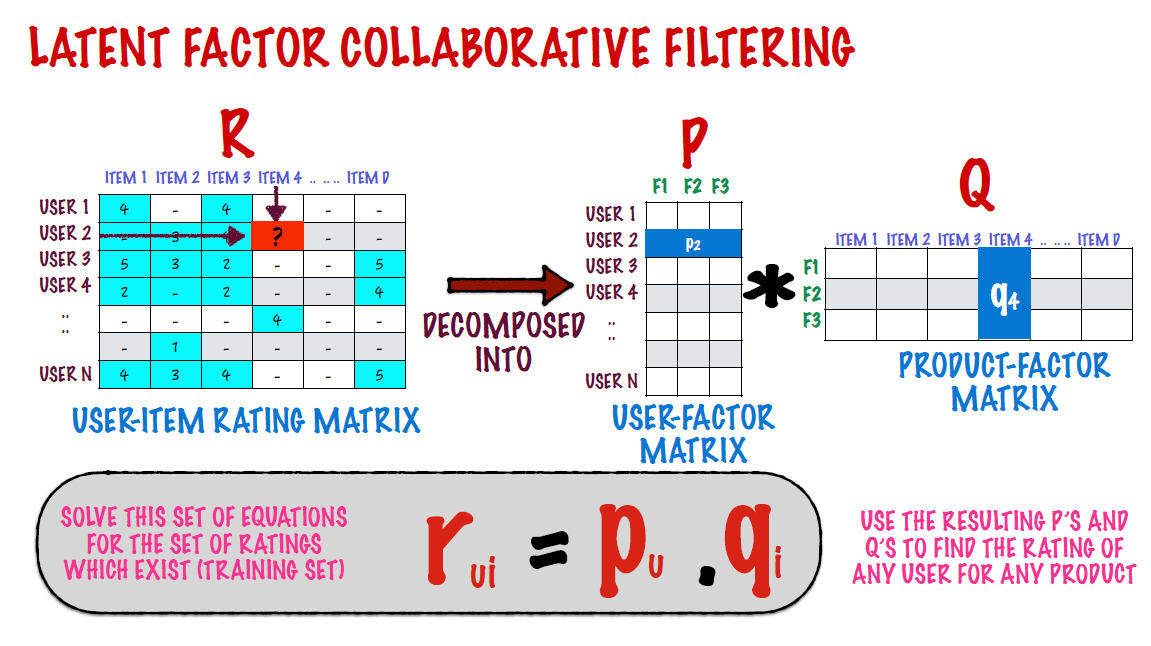

In [11]:
Image(filename='LATENT FACTOR COLLABORATIVE FILTERING.jpg')

### The  Function below is for calculating matrix factorization

In [30]:
def matrixFactorization(R, K, steps=10, gamma=0.001,lamda=0.02):
    # R is the user item rating matrix 
    # K is the number of factors we will find 
    # We'll be using Stochastic Gradient descent to find the factor vectors 
    # steps, gamma and lamda are parameters the SGD will use - we'll get to them
    # in a bit 
    N=len(R.index)# Number of users
    M=len(R.columns) # Number of items 
    P=pd.DataFrame(np.random.rand(N,K),index=R.index)
    # This is the user factor matrix we want to find. It will have N rows 
    # on for each user and K columns, one for each factor. We are initializing 
    # this matrix with some random numbers, then we will iteratively move towards 
    # the actual value we want to find 
    Q=pd.DataFrame(np.random.rand(M,K),index=R.columns)
    # This is the product factor matrix we want to find. It will have M rows, 
    # one for each product/item/movie. 
    for step in xrange(steps):
        # SGD will loop through the ratings in the user item rating matrix 
        # It will do this as many times as we specify (number of steps) or 
        # until the error we are minimizing reaches a certain threshold 
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    # For each rating that exists in the training set 
                    eij=R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    # This is the error for one rating 
                    # ie difference between the actual value of the rating 
                    # and the predicted value (dot product of the corresponding 
                    # user factor vector and item-factor vector)
                    # We have an error function to minimize. 
                    # The Ps and Qs should be moved in the downward direction 
                    # of the slope of the error at the current point 
                    P.loc[i]=P.loc[i]+gamma*(eij*Q.loc[j]-lamda*P.loc[i])
                    # Gamma is the size of the step we are taking / moving the value
                    # of P by  
                    # The value in the brackets is the partial derivative of the 
                    # error function ie the slope. Lamda is the value of the 
                    # regularization parameter which penalizes the model for the 
                    # number of factors we are finding. 
                    Q.loc[j]=Q.loc[j]+gamma*(eij*P.loc[i]-lamda*Q.loc[j])
        # At the end of this we have looped through all the ratings once. 
        # Let's check the value of the error function to see if we have reached 
        # the threshold at which we want to stop, else we will repeat the process
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    #Sum of squares of the errors in the rating
                    e= e + pow(R.loc[i,j]-np.dot(P.loc[i],Q.loc[j]),2)+lamda*(pow(np.linalg.norm(P.loc[i]),2)
                                                                              +pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
            break
        print step
    return P,Q

In [47]:
# Let's call this function now 
(P,Q)=matrixFactorization(userItemRatingMatrix.iloc[:100,:100],K=2,gamma=0.001,lamda=0.02, steps=25)
# Ideally we should run this over the entire matrix for a few 1000's steps, 
# This will be pretty expensive computationally. For now lets just do it over a 
# part of the rating matrix to see how it works. We've kept the steps to 25. 

0
1
2
3
4
5
6
7
8
9


#### Let's quickly use these ratings to find top recommendations for a activeUser 

In [48]:
predictItemRating=pd.DataFrame(np.dot(P.loc[activeUser],Q.T),index=Q.index,columns=['Rating'])
topRecommendations=pd.DataFrame.sort_values(predictItemRating,['Rating'],ascending=[0])[:5]
# We found the ratings of all movies by the active user and then sorted them to find the top 3 movies 
topRecommendationTitles=movieInfo.loc[movieInfo.itemId.isin(topRecommendations.index)]
print list(topRecommendationTitles.title)

['Star Wars (1977)', 'Good Will Hunting (1997)', 'L.A. Confidential (1997)', 'Titanic (1997)', "Schindler's List (1993)"]


The above recommendations relate to user 5 once again. These results seem to be more in line with the expected recommendations for a user that enjoys movies such as The Empire Strikes Back and Blade Runner. It is worth noting that it is possible these movies, although not part of the top 5, are movies the user already rated highly. In the future we need to ensure that the movies the user already watched are not part of the recommendations.

For the active user, only Star Wars was rated previously by the user. The others are movies that he has not watched, hence are recommendations we can show to the user.

### SPARK MLLib for Latent Factor Collaborative Filtering - Matrix Factorization
#### Alternative Least Squares Method - ALS

To run spark on local laptop/machine we install Spark from http://spark.apache.org/downloads.html, and follow the steps. 

1.Choose a Spark release: 2.0.0 (Jul 26 2016)1.6.2 
2.Choose a package type: Pre-built for Hadoop 2.6  
3.Choose a download type: Direct DownloadSelect Apache Mirror
4.Download Spark: spark-2.0.0-bin-hadoop2.6.tgz

Once downloaded, unzip the binaries in a specific folder like "C:\Apache-Spark\spark-2.0.0-bin-hadoop2.6" and change directory to this folder.
From shell/command prompt, run ./bin/spark-shell
This will start Spark Shell on the local machine.

Set the path variable or .bash_profile as needed: 
In case of Windows PATH: C:\Apache-Spark\spark-2.0.0-bin-hadoop2.6;C:\Apache-Spark\spark-2.0.0-bin-hadoop2.6\bin;

Next we will configure pyspark context in IPYTHON Notebook, which will enable us to use all the features of SPARK right from IPYTHON Notebook. pyspark is a python shell with all the fucntionalities and libraries from SPARK like MLLib etc.


In [16]:
# Below code will enable Spark Shell from IPYTHON
import sys
import os


spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError ('SPARK_HOME environment variable not set')

sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python\lib\pyspark.zip')) 
sys.path.insert(0, os.path.join(spark_home, 'python\lib\py4j-0.9-src.zip')) 

execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.0.0
      /_/

Using Python version 2.7.12 (default, Jun 29 2016 11:07:13)
SparkSession available as 'spark'.


In [17]:
from pyspark import SparkContext

In [19]:
uadatapath="C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project3/ml-100k/ml-100k/combined_user_movie_file.csv"
rawUserMovieData = sc.textFile(uadatapath)
rawUserMovieData.take(10)

[u',userId,itemId,rating,timestamp,title',
 u'0,196,242,3,881250949,Kolya (1996)',
 u'1,63,242,3,875747190,Kolya (1996)',
 u'2,226,242,5,883888671,Kolya (1996)',
 u'3,154,242,3,879138235,Kolya (1996)',
 u'4,306,242,5,876503793,Kolya (1996)',
 u'5,296,242,4,884196057,Kolya (1996)',
 u'6,34,242,5,888601628,Kolya (1996)',
 u'7,271,242,4,885844495,Kolya (1996)',
 u'8,201,242,4,884110598,Kolya (1996)']

In [20]:
# Filter the header out 
rawUserMovieData_wo_header = rawUserMovieData.filter(lambda x:"userId" not in x)

In [21]:
rawUserMovieData_wo_header.take(10)

[u'0,196,242,3,881250949,Kolya (1996)',
 u'1,63,242,3,875747190,Kolya (1996)',
 u'2,226,242,5,883888671,Kolya (1996)',
 u'3,154,242,3,879138235,Kolya (1996)',
 u'4,306,242,5,876503793,Kolya (1996)',
 u'5,296,242,4,884196057,Kolya (1996)',
 u'6,34,242,5,888601628,Kolya (1996)',
 u'7,271,242,4,885844495,Kolya (1996)',
 u'8,201,242,4,884110598,Kolya (1996)',
 u'9,209,242,4,883589606,Kolya (1996)']

In [22]:
rawUserMovieData_wo_header.count()

100000

In [23]:
# Extract the ratings column nwhere ratings is 4 or 5
# The code below gives the mean rating given to the movies (average of all the ratings) in the dataset
rawUserMovieData_wo_header.map(lambda x:float(x.split(",")[3])).stats()

(count: 100000, mean: 3.52986, stdev: 1.12566797076, max: 5.0, min: 1.0)

In [24]:
from pyspark.mllib.recommendation import Rating,ALS

Extract the ratings column nwhere ratings is 4 or 5
Since we are running this algorithm on a local machine, filtering low ratings will help

1. Reduce the amount of processing
2. Reduce the amount of data held in-memory

Since "rawUserMovieData_wo_header" is an RDD of Strings, we need to convert this into RDD of Rating objects
Additionally, we have filtered out any ratings that are below 4
Convert the list into a Rating object (Line #4 in below code snippet below)
Using persist function, ALS will pass over this RDD many times. Persisting will make the computation much faster

In [26]:
uaData=rawUserMovieData_wo_header\
    .map(lambda x:x.split(","))\
    .filter(lambda x: float(x[3])>=4)\
    .map(lambda x:Rating(x[1],x[2],x[3]))
uaData.persist()

PythonRDD[12] at RDD at PythonRDD.scala:48

In [27]:
uaData.take(10)

[Rating(user=226, product=242, rating=5.0),
 Rating(user=306, product=242, rating=5.0),
 Rating(user=296, product=242, rating=4.0),
 Rating(user=34, product=242, rating=5.0),
 Rating(user=271, product=242, rating=4.0),
 Rating(user=201, product=242, rating=4.0),
 Rating(user=209, product=242, rating=4.0),
 Rating(user=354, product=242, rating=5.0),
 Rating(user=199, product=242, rating=5.0),
 Rating(user=1, product=242, rating=5.0)]

Below we will train Alternating Least Squares Model available in Spark's MLLib
ALS has 2 methods : train and trainImplicit. Since our ratings are explicit we use the train method.
Explicit vs. implicit feedback
The standard approach to matrix factorization based collaborative filtering treats 
the entries in the user-item matrix as explicit preferences given by the user to the item, 
for example, users giving ratings to movies.
model = ALS.train(ratings, rank (Factors), numIterations, lambda)

In [28]:
model=ALS.train(uaData,10,5,0.01)

In [30]:
# Give below method a user id, and the number of recommendations we want
recommendations=model.recommendProducts(activeUser,5)

In [31]:
recommendations

[Rating(user=5, product=851, rating=6.061376066897271),
 Rating(user=5, product=896, rating=5.785945789735188),
 Rating(user=5, product=1449, rating=5.556606390584454),
 Rating(user=5, product=1512, rating=5.514398715142209),
 Rating(user=5, product=207, rating=5.451996231260588)]

In [32]:
# Split the row into a tuple of (Movie ID, Movie Name)

moviesPath="C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project3/ml-100k/ml-100k/u.item"
moviesLookup=sc.textFile(moviesPath).map(lambda x:x.split("|"))
moviesLookup.persist()

PythonRDD[137] at RDD at PythonRDD.scala:48

In [33]:
# Let's see which movies the user (specific user with userId) likes and rated 5

userMovies=rawUserMovieData_wo_header\
    .map(lambda x:x.split(","))\
    .filter(lambda x:int(x[1])==activeUser and int(x[3])>4)\
    .map(lambda x:x[2]).collect()

In [34]:
# Use the lookup action to print the names of the movies this user already likes
for movies in userMovies: 
    print moviesLookup.lookup(movies)

[u'Men in Black (1997)']
[u'Fargo (1996)']
[u'Return of the Jedi (1983)']
[u'Adventures of Priscilla, Queen of the Desert, The (1994)']
[u'This Is Spinal Tap (1984)']
[u'Raiders of the Lost Ark (1981)']
[u'Empire Strikes Back, The (1980)']
[u'Close Shave, A (1995)']
[u'Star Trek: The Wrath of Khan (1982)']
[u'Mystery Science Theater 3000: The Movie (1996)']
[u'Brady Bunch Movie, The (1995)']
[u'Blade Runner (1982)']
[u'Fish Called Wanda, A (1988)']
[u'Grand Day Out, A (1992)']
[u'Duck Soup (1933)']
[u'Wrong Trousers, The (1993)']
[u'Return of the Pink Panther, The (1974)']
[u'Blues Brothers, The (1980)']
[u'American Werewolf in London, An (1981)']
[u'Heathers (1989)']
[u'Harold and Maude (1971)']
[u'Serial Mom (1994)']
[u'Clerks (1994)']
[u'Heavy Metal (1981)']
[u'Forbidden Planet (1956)']
[u'Fear of a Black Hat (1993)']


The above movie list are movies that the active user has already watched and rated highly. From this list, it looks like the user likes Action, War/Drama movies. We can compare the results from recommendations to see if they fit these genres.

In [35]:
# Let’s print the recommended Movie names

for rating in recommendations: 
    print moviesLookup.lookup(str(rating.product))

[u'Two or Three Things I Know About Her (1966)']
[u'Sweet Hereafter, The (1997)']
[u'Pather Panchali (1955)']
[u'World of Apu, The (Apur Sansar) (1959)']
[u'Cyrano de Bergerac (1990)']


These recommendations again do not look great for the active user. It would be beneficial if we could find a way to incorporate the genre data provided in the initial data set. Our recommender system could benefit from running a cross check against the genre of the films and comparing to see if they match genres that the user enjoys.

### Conclusion- LFA and ALS

As we can see, Latent Factor analysis and ALS are pretty magical. We just need to have a good dataset with User-Product Ratings. The algorithm takes care of finding out the hidden factors that influence user’s preferences. Running this in a spark cluster with millions of records will help us get better results quickly and with less effort.

The above algorithms, although implemented correctly, further analysis should be done to check the results and confirm if the recommended movies are something that the user would actually enjoy. We should be able to vary parameters within these implementations to try and improve the results and make better recommendations.

## Association rules from the Movielens dataset

Association rules normally make sense with purchases / transactions datasets for example market basket analysis and hence stacking up specific products together logically. In this case, the rules we create may not make much sense, but they can help to determine and understand for example if a person who watches movie A will also be likely to have watched movie B, and hence we can see which movies are normally associate with each other with some minimum support and confidence. That way we can bucketize these movies together and display them on the screen of a specific user next to each other.

The itertools module below will help us generate all permutations of movies
We'll use that to find the possible rules and then filter for those with the required confidence

Since this is a very expensive operation to iterate over all the permutations of such a huge dataset, we are going to increase the required support to 40% for this to work on a single laptop machine. We can use the logic on a large dataset using Spark Cluster Computing environment, where multiple worker nodes can work on the data set in parallel and generate the results much faster.


In [36]:
import itertools

allitems=[]

def support(itemset):
    userList=userItemRatingMatrix.index
    nUsers=len(userList)
    ratingMatrix=userItemRatingMatrix
    for item in itemset:
        ratingMatrix=ratingMatrix.loc[ratingMatrix.loc[:,item]>0]
        #Subset the ratingMatrix to the set of users who have rated this item 
        userList=ratingMatrix.index
    # After looping through all the items in the set, we are left only with the
    # users who have rated all the items in the itemset
    return float(len(userList))/float(nUsers)
# Support is the proportion of all users who have watched this set of movies 

minsupport=0.4
for item in list(userItemRatingMatrix.columns):
    itemset=[item]
    if support(itemset)>minsupport:
        allitems.append(item)

# We are now left only with the items which have been rated by atleast 40% of the users

In [37]:
print 'Number of movies were watched by atleast 40% of the users = ' , (len(allitems))
print '\nFrom these movies we will generate rules and test again for support and confidence'

Number of movies were watched by atleast 40% of the users =  17

From these movies we will generate rules and test again for support and confidence


In [38]:
allitems_df = pd.DataFrame(allitems, columns=['itemId'])

In [39]:
print 'Movies were watched by atleast 40% of the users\n\n', pd.merge(movieInfo, allitems_df)

print '\nWe can also say that these are best of the best movies within this dataset, which are watched by most users'

Movies were watched by atleast 40% of the users

    itemId                             title
0        1                  Toy Story (1995)
1        7             Twelve Monkeys (1995)
2       50                  Star Wars (1977)
3       56               Pulp Fiction (1994)
4       98  Silence of the Lambs, The (1991)
5      100                      Fargo (1996)
6      117                  Rock, The (1996)
7      121     Independence Day (ID4) (1996)
8      127             Godfather, The (1972)
9      174    Raiders of the Lost Ark (1981)
10     181         Return of the Jedi (1983)
11     237              Jerry Maguire (1996)
12     258                    Contact (1997)
13     286       English Patient, The (1996)
14     288                     Scream (1996)
15     294                  Liar Liar (1997)
16     300              Air Force One (1997)

We can also say that these are best of the best movies within this dataset, which are watched by most users


The below snippet will generate all possible 2 item rules which satisfy the support and confidence constraints. 
By Iterating over i, we can continue on  for finding 3 item rules or even n item rules. At each step make sure that every rule satisfies minconfidence and minsupport

In [40]:
minconfidence=0.2
assocRules=[]
i=2
for rule in itertools.permutations(allitems,i):
    #Generates all possible permutations of i items from the remaining list of movies 
    from_item=[rule[0]]
    to_item=rule
    # each rule is a tuple of i items 
    confidence=support(to_item)/support(from_item)
    if confidence>minconfidence and support(to_item)>minsupport:
        assocRules.append(rule)

Below are the 2 itemset rules for movies, i.e. the movies that are watched together. Since the Movie ID's are not intuitive, we look the ids up with the movie titles and see if these makes sense.

In [47]:
assocRules

[(1, 50),
 (50, 1),
 (50, 100),
 (50, 174),
 (50, 181),
 (100, 50),
 (174, 50),
 (181, 50)]

In [48]:
assocRules_df = pd.DataFrame(assocRules, columns=['MovieId1', 'MovieId2'])

In [49]:
assocRules_df1 = pd.merge(movieInfo, assocRules_df, how='inner', left_on=['itemId'], right_on=['MovieId1'])
assocRules_df2 = pd.merge(movieInfo, assocRules_df1, how='inner', left_on=['itemId'], right_on=['MovieId2'])
for col in ['title', 'itemId','itemId_x','itemId_y']:
    if col in assocRules_df2:
        del assocRules_df2[col]

In [50]:
assocRules_df2

,title_x,title_y,MovieId1,MovieId2
0,Toy Story (1995),Star Wars (1977),50,1
1,Star Wars (1977),Toy Story (1995),1,50
2,Star Wars (1977),Fargo (1996),100,50
3,Star Wars (1977),Raiders of the Lost Ark (1981),174,50
4,Star Wars (1977),Return of the Jedi (1983),181,50
5,Fargo (1996),Star Wars (1977),50,100
6,Raiders of the Lost Ark (1981),Star Wars (1977),50,174
7,Return of the Jedi (1983),Star Wars (1977),50,181


### Conclusion on Association rule

The Movies that are watched together with minSupport = 40% and minconfidence=20% are shown in the table above. As we can guess, the most popular movies are watched by most users a lot of the time. It makes a lot of sense that people that watched Star Wars also watched Raiders of the Lost Ark and Return of the Jedi as these movies are both made by Lucas Films and have a similar audience in general. It is interesting to see that Toy Story and Star Wars are closely related.

By running the same logic to generate 3 item rules or even n item rules, we can find the movies that are normally watched together by most users and hence we can recommend those movies to the users who fall in that basket of rules set.

## Deployment

Nowadays, recommendation systems are increasingly becoming more and more popular and essential to Online Marketing. The recommender systems are also used extensively by some of the most popular content delivery companies, e-commerce stores and even the banking and financial industry as well. Unlike offline stores where we have people selling products, online stores have no or very few sales people but a huge selection of products for the consumers, like Amazon for example. In these situations, its impossible for a human to recommend and sell a product to the companies customers. That is why recommender engines are very important and useful. The above recommendation system would be deployed in an online system to help the users navigate the maze of online stores, find items users are most likely to look for, find items that they might like as well, and use the data of the same user or other similar users to do all this, by looking at what users bought in the past, what they browsed, what they clicked, what products/items they rated and what other similar users did.

For this movie recommender system, a company like Amazon, Netflix or Hulu might be interested in deploying the system to help their users find movies they like based on movies they have rated and watched. Other data that might be useful to predict the movies on are genre breakdowns. Although this can be gleamed from the similarity of movies watched by users, knowing this information can help make a more accurate prediction recommendation system. A model like this needs to be updated as often as necessary to gather new user data and update the ratings for older users that have watched and rated new movies. This would likely be done on a weekly basis for a smaller company, but large companies with lots of traffic would want to update daily possibly.